In [1]:

import os
import os.path as osp
import sys
import time



In [2]:
from data import *
from utils.augmentations import SSDAugmentation
from layers.modules import MultiBoxLoss
from ssd import build_ssd

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision as tv
import torch.optim as optim



In [4]:
import torch.utils.data as data
import torchvision.datasets

import numpy as np
from PIL import Image
import argparse

from matplotlib import pyplot as plt
import pandas as pd
import cv2 
import pickle as pkl
import random
import tarfile
import collections
import math
import datetime
import pickle


In [5]:

from config_vgg16_ssd import *
import xml.etree.ElementTree as ET

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:

def xavier(param):
    nn.init.xavier_uniform(param)


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        xavier(m.weight.data)
        m.bias.data.zero_()


In [12]:
def train(device, resume=None):
    
    #use voc config 
    cfg = voc
 
    ssd_net = build_ssd('train', cfg['min_dim'], cfg['num_classes'])
    dataset = VOCDetection(root=dataset_root, image_sets=[('2012', 'train')],
                            transform=SSDAugmentation(cfg['min_dim'],
                             MEANS))
 

    if resume:
        print('Resuming training, loading previous training at ',resume)
        ssd_net.load_weights(resume) 
    else:
        vgg_weights = torch.load(basenet)
        print('Loading base network...')
        ssd_net.vgg.load_state_dict(vgg_weights)
        print('Initializing weights...')
        ssd_net.extras.apply(weights_init)
        ssd_net.loc.apply(weights_init)
        ssd_net.conf.apply(weights_init)
    
    net = ssd_net
    
    if device:
        net = torch.nn.DataParallel(ssd_net)
        torch.backends.cudnn.benchmark = True
        net = net.to(device)
 
    optimizer = optim.RMSprop(net.parameters(), lr=lr,weight_decay=weight_decay)  
    
    criterion = MultiBoxLoss(cfg['num_classes'], 0.5, True, 0, True, 3, 0.5,
                             False, torch.cuda.is_available())

    
    net.train()
    mode = 'train'
    

    loc_loss = 0
    conf_loss = 0
    epoch = 0
    print('Loading the dataset...')

    epoch_size = len(dataset) // batch_size
    print('Training SSD on: ',mode)

    step_index = 0

    #based on adapted code
    train_data_loader = data.DataLoader(dataset, batch_size=32, num_workers=4, shuffle=True,\
                               collate_fn=detection_collate,pin_memory=True)
    
    print("Images in the training set = " + str(len(dataset)))
    print("Images in a mini-batch = "+str(batch_size))
    print("mini-batches = " + str(len(train_data_loader)))
    
    
     # create batch iterator
    batch_iterator = iter(train_data_loader)
    print("STARTING - ITERATIONS")
    
    
    l_loss = []
    c_loss = []
    itr = []
    
    #for 10000 iterations - takes long
    for iteration in range(0, 2000):
        
        if iteration != 0 and (iteration % epoch_size == 0):
            # reset epoch loss counters
            loc_loss = 0
            conf_loss = 0
            epoch += 1

        if iteration in cfg['lr_steps']:
            step_index += 1
            lr_dec = lr * (gamma ** (step_index))
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_dec

            
        ## load train data
        try:
            images, targets = next(batch_iterator)
        except StopIteration:
            batch_iterator = iter(train_data_loader)
            images, targets = next(batch_iterator)


        
        if device:
            images = images.cuda()
            targets = [ann.cuda() for ann in targets]
        else:
            images = images
            targets = [ann for ann in targets]
        
        # forward
        t0 = time.time()
        out = net(images)

        # backprop
        optimizer.zero_grad()

        loss_l, loss_c = criterion(out, targets)
        loss = loss_l + loss_c

        loss.backward()

        optimizer.step()

        l_loss.append(loss_l.data.item())
        c_loss.append(loss_c.data.item())
        
        t1 = time.time()
        loc_loss += loss_l.data.item()
        conf_loss += loss_c.data.item()
        
        itr.append(iteration)
        
        if iteration % 10 == 0:
            print('timer: %.4f sec.' % (t1 - t0))
            print('iter ' + repr(iteration) + ' || Loss: %.4f ||' % (loss.data.item()), end=' ')
            currentDT = datetime.datetime.now()
            print (currentDT.strftime("%H:%M:%S %p"))
            print("\n")
        
        
        if iteration != 0 and iteration % 100 == 0:
            print('Saving state, iter:', iteration)
            iter_name = math.ceil(iteration/100)*100
            torch.save(ssd_net.state_dict(), 'trained_weights/ssd_VOC_RMSprop_' +repr(iter_name) + '.pth')
            with open('trained_weights/vgg16_ssd_stats_RMSprop.pkl','wb') as f:
                pkl.dump([l_loss, c_loss, itr], f)
                

    torch.save(ssd_net.state_dict(),
               save_folder + data_set + '.pth') 

### 

In [13]:
!cat config_vgg16_ssd.py

#Initialize pointers
data_set = 'VOC'
dataset_root = voc_root = '//datasets/ee285f-public/PascalVOC2012/'
save_folder = 'trained_weights/'
eval_save_folder = 'eval/'
devkit_path = 'devkit_path/'
output_dir = "out/"

#Run related metaparameters

batch_size = 32
resume = None

#Optimization metaparameters
lr = 1e-3
momentum = 0.9
weight_decay = 5e-4
gamma = 0.1
    
confidence_threshold = 0.01
top_k = 5
cleanup = True

YEAR = '2012'
dataset_mean = (104, 117, 123)
set_type = 'train'

# Please Change if required
trained_model = 'weights/ssd_pretrained.pth'
basenet = 'weights/vgg16_reducedfc.pth'

In [14]:
train(device, resume)

change log in ssd.py
Loading base network...
Initializing weights...
Loading the dataset...
Training SSD on:  train
Images in the training set = 5717
Images in a mini-batch = 32
mini-batches = 179


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


STARTING - ITERATIONS
timer: 0.5934 sec.
iter 0 || Loss: 26.4075 || 23:08:20 PM


timer: 0.6966 sec.
iter 10 || Loss: 25.1958 || 23:08:27 PM


timer: 0.5706 sec.
iter 20 || Loss: 17.7655 || 23:08:34 PM


timer: 0.6960 sec.
iter 30 || Loss: 12.0922 || 23:08:42 PM


timer: 0.7648 sec.
iter 40 || Loss: 9.8675 || 23:08:49 PM


timer: 0.5860 sec.
iter 50 || Loss: 9.7384 || 23:08:56 PM


timer: 0.6960 sec.
iter 60 || Loss: 8.4308 || 23:09:05 PM


timer: 0.6958 sec.
iter 70 || Loss: 8.7038 || 23:09:12 PM


timer: 0.6975 sec.
iter 80 || Loss: 7.7706 || 23:09:19 PM


timer: 0.6988 sec.
iter 90 || Loss: 8.1916 || 23:09:26 PM


timer: 0.6942 sec.
iter 100 || Loss: 8.3539 || 23:09:33 PM


Saving state, iter: 100
timer: 0.5846 sec.
iter 110 || Loss: 8.1949 || 23:09:40 PM


timer: 0.6680 sec.
iter 120 || Loss: 7.9761 || 23:09:48 PM


timer: 0.6723 sec.
iter 130 || Loss: 8.0800 || 23:09:55 PM


timer: 0.6955 sec.
iter 140 || Loss: 7.8857 || 23:10:03 PM


timer: 0.6725 sec.
iter 150 || Loss: 7.4961 ||

timer: 0.6880 sec.
iter 1290 || Loss: 9.5053 || 23:24:32 PM


timer: 0.5960 sec.
iter 1300 || Loss: 10.7347 || 23:24:39 PM


Saving state, iter: 1300
timer: 0.6965 sec.
iter 1310 || Loss: 8.0840 || 23:24:47 PM


timer: 0.5980 sec.
iter 1320 || Loss: 8.5332 || 23:24:53 PM


timer: 0.5954 sec.
iter 1330 || Loss: 8.3808 || 23:25:01 PM


timer: 0.5788 sec.
iter 1340 || Loss: 8.6044 || 23:25:08 PM


timer: 0.5961 sec.
iter 1350 || Loss: 7.8561 || 23:25:16 PM


timer: 0.6957 sec.
iter 1360 || Loss: 7.7970 || 23:25:23 PM


timer: 0.6771 sec.
iter 1370 || Loss: 8.2621 || 23:25:31 PM


timer: 0.7959 sec.
iter 1380 || Loss: 8.3572 || 23:25:38 PM


timer: 0.5823 sec.
iter 1390 || Loss: 8.8535 || 23:25:46 PM


timer: 0.5966 sec.
iter 1400 || Loss: 8.6944 || 23:25:52 PM


Saving state, iter: 1400
timer: 0.6814 sec.
iter 1410 || Loss: 8.1969 || 23:26:00 PM


timer: 0.5956 sec.
iter 1420 || Loss: 7.9709 || 23:26:07 PM


timer: 0.4926 sec.
iter 1430 || Loss: 8.2410 || 23:26:14 PM


timer: 0.5951 sec.


# 1000 iter

Text(0, 0.5, 'Loss')

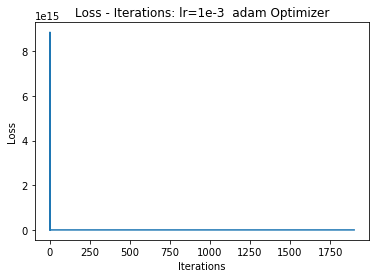

In [11]:
with open('trained_weights/vgg16_ssd_stats_RMSprop.pkl','rb') as f:
    l_loss, c_loss, itr = pickle.load(f)

l_loss = np.asarray(l_loss)
c_loss = np.asarray(c_loss)
itr = np.asarray(itr)
plt.plot(itr,l_loss+c_loss)
plt.title('Loss - Iterations: lr=1e-3  RMS prop Optimizer')
plt.xlabel('Iterations')
plt.ylabel('Loss')